# Wind field modelling for tropical cyclones

Based on the Python package CLIMADA, using the Holland (2008) model:
- Tutorial: https://climada-python.readthedocs.io/en/stable/tutorial/climada_hazard_TropCyclone.html
- Read the docs on TCTracks: https://github.com/CLIMADA-project/climada_python/blob/main/climada/hazard/tc_tracks.py

### For the synthetic tropical cyclone database STORM

- Link for downloads: https://data.4tu.nl/articles/dataset/STORM_IBTrACS_present_climate_synthetic_tropical_cyclone_tracks/12706085
- Article of Nadia Bloemendaal (KNMI) et al. (2020): https://www.nature.com/articles/s41597-020-0381-2

### Overview

This notebook follows the steps below: 
1. Preparations: loading packages and setting a standard for fonts/colour use
2. Generate centroids: create the points for which the modelling will take place
3. Load tracks: loading the TC tracks to be used
4. Model the hazard: modelling wind fields for all selected tracks, output to be saved
5. EXTRA CODE: Running 10 X 1,000 years of data in one cell

# 1. Preparations

### 1a. Load packages

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import time
import os
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [10]:
import climada
from climada.hazard import TCTracks
from climada.hazard import TropCyclone, Centroids
from climada.util.constants import SYSTEM_DIR

### 1b. Import functions out python file

In [12]:
import importlib
import TC_hazard_modelling

importlib.reload(TC_hazard_modelling)

# 2. Generate centroids
from TC_hazard_modelling import create_centroids_from_shapefiles
from TC_hazard_modelling import plot_all_grids_with_zoom

# 3. Load tracks
from TC_hazard_modelling import select_tracks
from TC_hazard_modelling import extract_selected_tracks


#4. Model the hazard
from TC_hazard_modelling import compute_windfields

### 1c. Create color palette and chose font

In [14]:
my_colors = {
    "510brown": "#c6bc8b",
    "510darkblue": "#00214d",
    "510lightblue": "#d4e6ff",
    "510red": "#dd281f",
    "510lightred": "#ff7876", 
    "510purple": "#958dbe"
}

plt.rcParams["font.family"] = "Arial"

# 2. Generate centroids: a grid of points from the country shapefiles

### 2a. Create a list of centroids per country

In [17]:
centroids_list, shapefiles_list = create_centroids_from_shapefiles(folder_path = "0-level-Leeward++",      # Path to folder of shapefile(s) 
                                                                   resolution_km = 2,                      # Desired resolution for point grid (km)
                                                                   buffer_km = 0)                          # Optional buffer around the borders of a shapefile (km)

Created centroids for 14 shapefiles.


### 2b. Optional: plot the created point grid

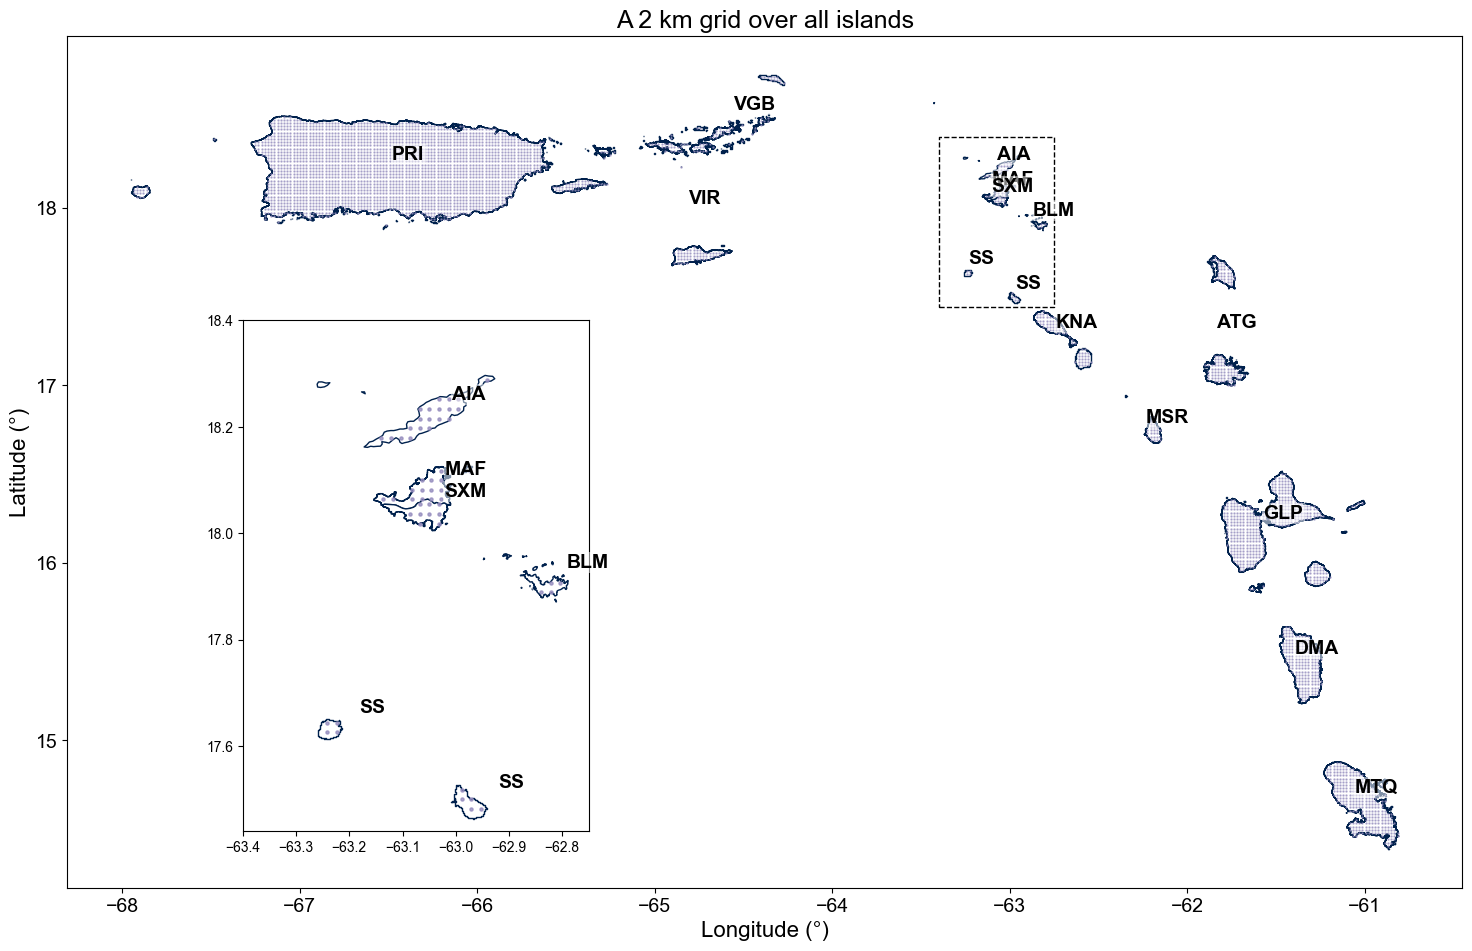

In [19]:
plot_all_grids_with_zoom(folder_path = "0-level-Leeward++",             # path to folder of shapefile(s)
                         shapefiles_list = shapefiles_list,             # Output of step 2a
                         centroids_list = centroids_list,                # Output of step 2a
                         my_colors = my_colors,                         # Optional: created in step 1
                         resolution_km = 2,                             # Same value as above
                         zoom_extent =(-63.4, -62.75, 17.44, 18.4))     # Zoomed view for readability

# Optional: Save plot as pdf/png/other
output_path = 'wind_figures/IBTrACS_windfields_pointgridLeewardIslands++.png'
plt.savefig(output_path, bbox_inches = 'tight')

plt.show();

# 3. Load STORM data

### 3a. Use TCTracks to import tracks from STORM
The STORM data needs to be downloaded first, using the link in the description above. It gives 10 files in total, each containing 1000 years of synthetic data. The code is written such that only 1 file is processed at once, since not always 10,000 years is necessary for the desired analysis. Below, an extra code is given that loops over all 10 files. 

In [22]:
path = 'STORM_PresentDayClimate/VERSIE4/STORM_DATA_IBTRACS_NA_1000_YEARS_0.txt'    # Path to downloaded data [txt file]
tracks = TCTracks.from_simulations_storm(path)                                     # Optional: add 'years = ...' to use a smaller subset of the data

print("Number of tracks:", tracks.size)

Number of tracks: 10522


### 3b. Pre-select tracks passing the study area

In [24]:
tracks_LeewardIslands = select_tracks(tracks = tracks,                          # Output of step 3a
                                      lon_min = 360-69, lon_max = 360-58,       # -69 to -58 degrees West,
                                      lat_min = 12, lat_max = 21)               # 12 to 21 degrees North

print("Number of tracks:", tracks_LeewardIslands.size)

Number of tracks: 2325


### 3c. Create a list of the storm IDs of the selected tracks and load tracks again

In [26]:
tr_ = extract_selected_tracks(tracks = tracks_LeewardIslands)

Number of tracks: 2325


# 4. Model the hazard

### 4a. Generate wind fields and save the maximum intensity for all storms per point in CSV files
_Runs in +/- 50 minutes_

In [29]:
start_time = time.time()

df = compute_windfields(tc_tracks_dict = tr_,                                                     # Output of step 3c
                        centroids_list = centroids_list,                                          # Output of step 2a
                        shapefiles = shapefiles_list,                                              # Output of step 2a
                        output_csv_path = "wind_output/STORM_windfields_2kmgrid_Leeward++_0.csv")

print(f'Running time: {(time.time() - start_time):.2f} seconds')

All results saved to wind_output/STORM_windfields_2kmgrid_Leeward++_0.csv
Running time: 1520.11 seconds


### 4b. Optional: check output

In [31]:
print(f"Size of output: {df.size}")
df.head()

Size of output: 25591275


lon        lat  \
SID                                        ISO                         
STORM_DATA_IBTRACS_NA_1000_YEARS_0.txt-0-0 AIA -63.139555  18.178913   
                                           AIA -63.121537  18.178913   
                                           AIA -63.103519  18.178913   
                                           AIA -63.085501  18.178913   
                                           AIA -63.085501  18.196931   

                                                max_wind_speed_mps  
SID                                        ISO                      
STORM_DATA_IBTRACS_NA_1000_YEARS_0.txt-0-0 AIA                 0.0  
                                           AIA                 0.0  
                                           AIA                 0.0  
                                           AIA                 0.0  
                                           AIA                 0.0

# 5. EXTRA CODE: Running 10 X 1,000 years of data in one cell
_Runs in +/- 3 hours_

In [33]:
start_time = time.time()

files = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for file in files:
    time0 = time.time()
    print(f'Starting wind field modelling for STORM file {file}...')
    
    path = f'STORM_PresentDayClimate/VERSIE4/STORM_DATA_IBTRACS_NA_1000_YEARS_{file}.txt'    # Path to downloaded data [txt file]
    tracks = TCTracks.from_simulations_storm(path)

    tracks_LeewardIslands = select_tracks(tracks = tracks,
                                      lon_min = 360-69, lon_max = 360-58,
                                      lat_min = 12, lat_max = 21)

    tr_ = extract_selected_tracks(tracks = tracks_LeewardIslands)

    output_path = f"wind_output/STORM_windfields_2kmgrid_Leeward++_{file}.csv"
    df = compute_windfields(tc_tracks_dict = tr_,
                            centroids_list = centroids_list,
                            shapefiles = shapefiles_list,
                            output_csv_path = output_path)

    print(f'Saved wind field output for file {file} to {output_path}')
    print(f'Size of output: {df.size}')
    print(f'Running time: {(time.time() - time0):.2f} seconds')
    print('\n')

print(f'Total running time: {(time.time() - start_time):.2f} seconds')

Starting wind field modelling for STORM file 0...
Number of tracks: 2325
All results saved to wind_output/STORM_windfields_2kmgrid_Leeward++_0.csv
Saved wind field output for file 0 to wind_output/STORM_windfields_2kmgrid_Leeward++_0.csv
Size of output: 25591275
Running time: 1612.45 seconds


Starting wind field modelling for STORM file 1...
Number of tracks: 2202
All results saved to wind_output/STORM_windfields_2kmgrid_Leeward++_1.csv
Saved wind field output for file 1 to wind_output/STORM_windfields_2kmgrid_Leeward++_1.csv
Size of output: 24237414
Running time: 1494.34 seconds


Starting wind field modelling for STORM file 2...
Number of tracks: 2288
All results saved to wind_output/STORM_windfields_2kmgrid_Leeward++_2.csv
Saved wind field output for file 2 to wind_output/STORM_windfields_2kmgrid_Leeward++_2.csv
Size of output: 25184016
Running time: 1523.72 seconds


Starting wind field modelling for STORM file 3...
Number of tracks: 2394
All results saved to wind_output/STORM_win